## Reproductible fitting 

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import scipy

from jmstate import MultiStateJointModel
from jmstate.utils import *

torch.manual_seed(42)

In [96]:
def log_weibull(t1, t0, lambda_, rho_):
    t = t1 - t0
    lambda_ = torch.as_tensor(lambda_, dtype=torch.float32)
    rho_ = torch.as_tensor(rho_, dtype=torch.float32)
    eps = 1e-8
    t = t + eps
    return torch.log(rho_ / lambda_) + (rho_ - 1) * torch.log(t / lambda_)


def double_slope(t, x, psi):
    x0 = psi[:, [0]]
    a = psi[:, [1]]
    b1 = psi[:, [2]]
    b2 = psi[:, [3]]
    corr = torch.where(t > x0, (b2 - b1) * (t - x0), torch.zeros_like(t))
    return (a + b1 * t + corr).unsqueeze(-1)


def double_slope_grad(t, x, psi):
    x0 = psi[:, [0]]
    b1 = psi[:, [2]]
    b2 = psi[:, [3]]
    return torch.where(t <= x0, b1, b2).unsqueeze(-1)


def link(t, x, psi):
    return torch.cat([double_slope(t, x, psi), double_slope_grad(t, x, psi)], dim=-1)


f = lambda gamma, b: gamma + b

In [97]:
##############################################

lambda_T01 = 6.33
rho_T01 = 1.90
lambda_T02 = 4.24
rho_T02 = 3.16
lambda_T12 = 5.70
rho_T12 = 1.48

##############################################

gamma = torch.tensor([1.45, 2.33, -1.38, 0.17])
Q_inv = torch.tensor([2.25, 1.34, 0.51, 0.77])
R_inv = torch.tensor([1.19])
Q_sqrt = torch.matrix_exp(-torch.diag(Q_inv))
R_sqrt = torch.exp(-R_inv)
alphas = {
    (0, 1): torch.tensor([0.07, 5.16]),
    (0, 2): torch.tensor([-0.12, 4.84]),
    (1, 2): torch.tensor([-0.02, 0.49]),
}
betas = {
    (0, 1): torch.tensor([-1.34]),
    (0, 2): torch.tensor([-0.91]),
    (1, 2): torch.tensor([-0.54]),
}

##############################################

real_params = ModelParams(gamma, (Q_inv, "diag"), (R_inv, "ball"), alphas, betas)

In [98]:
log_weibull_T01 = lambda t1, t0: log_weibull(t1, t0, lambda_T01, rho_T01)
log_weibull_T02 = lambda t1, t0: log_weibull(t1, t0, lambda_T02, rho_T02)
log_weibull_T12 = lambda t1, t0: log_weibull(t1, t0, lambda_T12, rho_T12)

surv = {
    (0, 1): (log_weibull_T01, link),
    (0, 2): (log_weibull_T02, link),
    (1, 2): (log_weibull_T12, link),
}

In [99]:
model_design = ModelDesign(f, double_slope, surv)

In [100]:
real_model = MultiStateJointModel(model_design, real_params)

n, p = 500, 1
t = torch.linspace(0, 15, 16)
c = torch.rand(n) * 5 + 10
x = torch.randn(n, 1)
b = torch.randn(n, real_params.gamma.shape[0]) @ Q_sqrt
psi = f(real_params.gamma, b)

In [101]:
trajectories_init = [[(0.0, 0)] for _ in range(n)]

sample_data = SampleData(x, trajectories_init, psi)

trajectories = real_model.sample_trajectories(sample_data, c)

In [102]:
c_min = torch.tensor(
    [
        (
            min(c[i].item(), trajectories[i][-1][0])
            if trajectories[i][-1][1] == 2
            else c[i].item()
        )
        for i in range(len(trajectories))
    ]
)

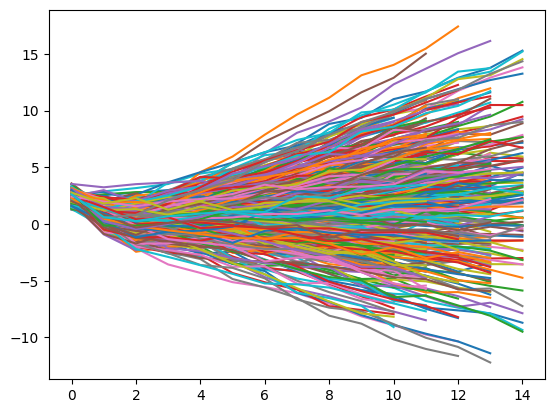

In [103]:
y = model_design.h(t, x, psi)
y += torch.randn_like(y) * R_sqrt
y[t.repeat(n, 1) > c.view(-1, 1)] = torch.nan
plt.plot(t, y.squeeze(-1).T)
plt.show()

In [104]:
init_params = ModelParams(
    torch.zeros_like(gamma),
    (torch.zeros_like(Q_inv), "diag"),
    (torch.zeros_like(R_inv), "ball"),
    {k: torch.zeros_like(v) for k, v in alphas.items()},
    {k: torch.zeros_like(v) for k, v in betas.items()},
)

In [105]:
data = ModelData(x, t, y, trajectories, c)

In [106]:
buckets = build_buckets(trajectories)
print([(key, buckets[key][0].numel()) for key in buckets.keys()])

[((0, 1), 191), ((1, 2), 175), ((0, 2), 296)]


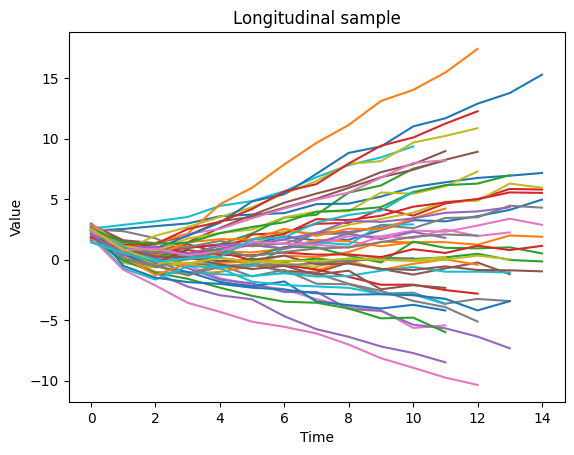

In [113]:
plt.plot(t, y[:50].squeeze(-1).T)
plt.title("Longitudinal sample")
plt.xlabel("Time")
plt.ylabel("Value")
plt.savefig("Figures/sample_plot.png")
plt.show()

In [108]:
history = []
acceptance = []
step_sizes = []


def callback():
    history.append([p.detach().clone() for p in model.params_.as_list])
    acceptance.append(model.sampler_.acceptance_rate)
    step_sizes.append(model.sampler_.step_size)


model = MultiStateJointModel(model_design, init_params)
model.fit(data, callback=callback, n_iter=3000, batch_size=4)

Fitting joint model:   1%|▏         | 43/3000 [00:07<08:51,  5.56it/s]


KeyboardInterrupt: 

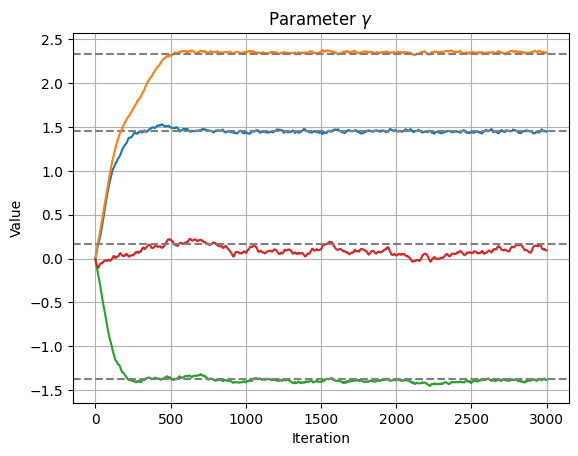

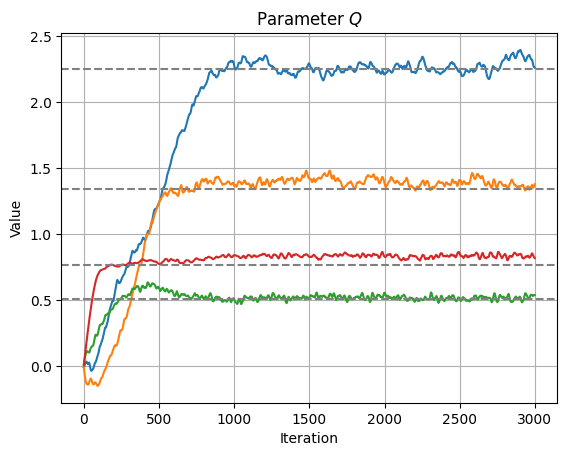

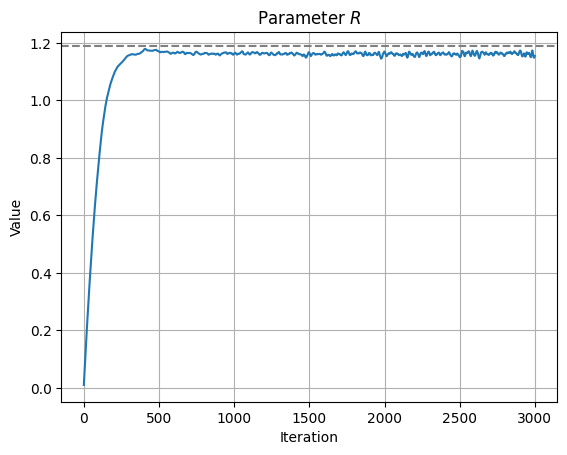

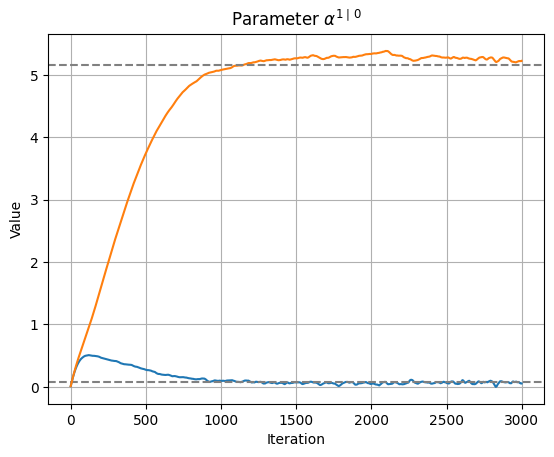

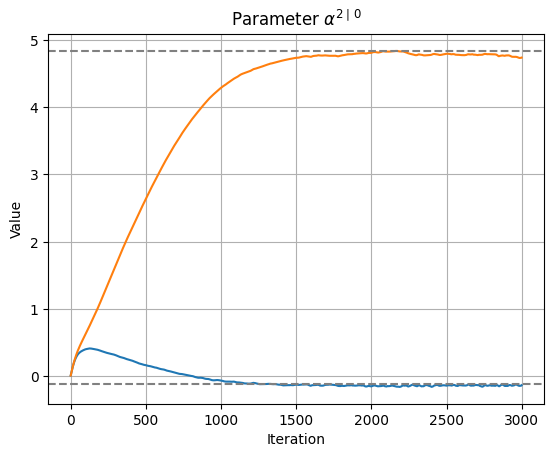

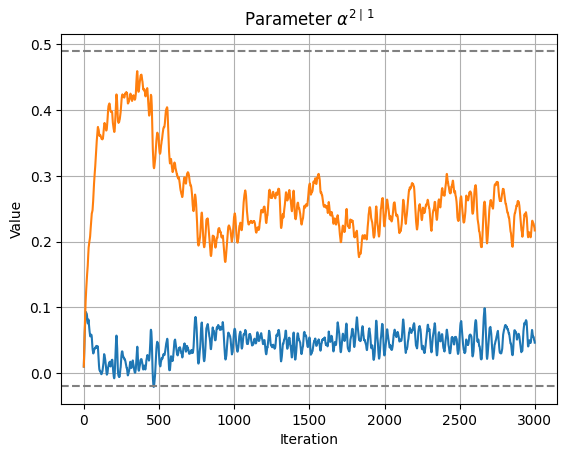

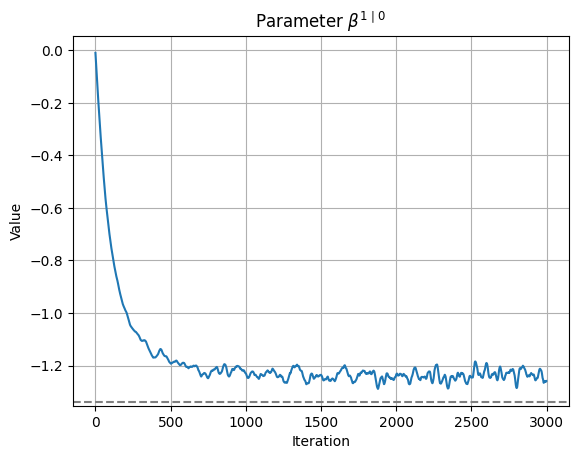

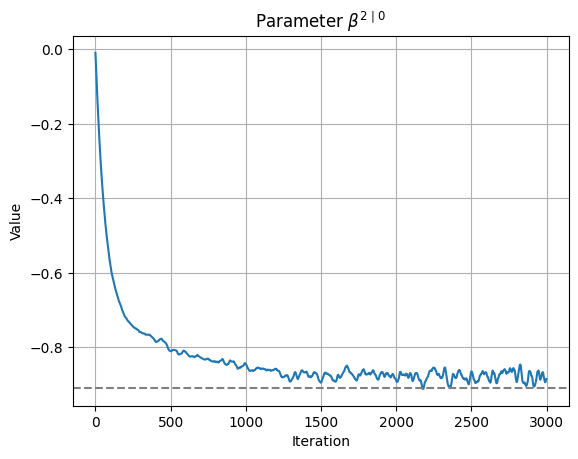

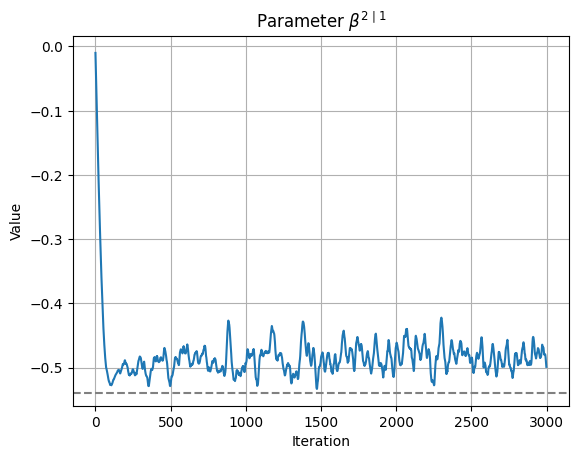

In [ ]:
real_params_list = real_params.as_list
names = (
    r"$\gamma$",
    r"$Q$",
    r"$R$",
    r"$\alpha^{1 \mid 0}$",
    r"$\alpha^{2 \mid 0}$",
    r"$\alpha^{2 \mid 1}$",
    r"$\beta^{1 \mid 0}$",
    r"$\beta^{2 \mid 0}$",
    r"$\beta^{2 \mid 1}$",
)

for i in range(len(history[0])):
    history_vstack = np.vstack([elt[i].numpy().reshape(1, -1) for elt in history])

    for j in range(history_vstack.shape[1]):
        plt.plot(np.arange(history_vstack.shape[0]), history_vstack[:, j])

        plt.axhline(y=float(real_params_list[i][j]), linestyle="--", color="gray")

    plt.title(f"Parameter {names[i]}")
    plt.xlabel("Iteration")
    plt.ylabel("Value")
    plt.grid(True)
    plt.savefig(
        f"Convergence/{names[i].strip('$').replace('^{', '_').replace('}', '').replace(' ', '').replace('\\mid', '').replace('\\', '')}_plot.png"
    )
    plt.show()

In [ ]:
print("Estimation")
print(model.params_)

Estimation
ModelParams(gamma=tensor([ 1.4490,  2.3486, -1.3854,  0.0932], requires_grad=True), Q_repr=(tensor([2.2615, 1.3780, 0.5382, 0.8190], requires_grad=True), 'diag'), R_repr=(tensor([1.1547], requires_grad=True), 'ball'), alphas={(0, 1): tensor([0.0545, 5.2213], requires_grad=True), (0, 2): tensor([-0.1343,  4.7374], requires_grad=True), (1, 2): tensor([0.0464, 0.2170], requires_grad=True)}, betas={(0, 1): tensor([-1.2593], requires_grad=True), (0, 2): tensor([-0.8852], requires_grad=True), (1, 2): tensor([-0.4988], requires_grad=True)})


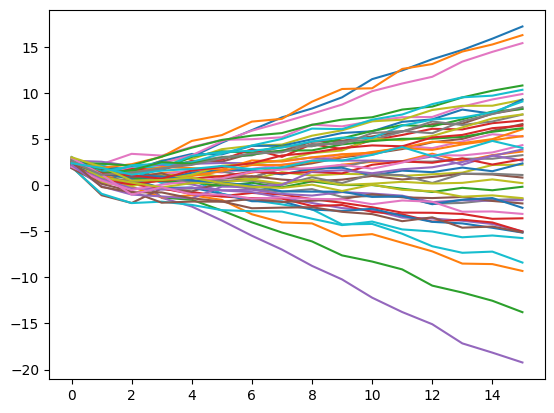

In [ ]:
model = real_model

N = 50

Q = model.params_.get_precision("Q").detach()
Q = torch.linalg.inv(Q)

R = model.params_.get_precision("R").detach()
R = torch.linalg.inv(R)

b_sim = torch.randn(N, model.params_.gamma.detach().shape[0]) @ torch.tensor(
    scipy.linalg.sqrtm(Q.numpy())
)
psi_sim = f(model.params_.gamma, b_sim)
x_sim = torch.randn(N, 1)

y_sim = model.model_design.h(t, x_sim, psi_sim)
y_sim += torch.randn_like(y_sim) @ torch.tensor(scipy.linalg.sqrtm(R.numpy()))
plt.plot(t, y_sim.squeeze(-1).T.detach().numpy())
plt.show()

In [ ]:
trajectories_init = [trajectory[:1] for trajectory in trajectories[:N]]

sample_data = SampleData(x_sim, trajectories_init, psi_sim)

trajectories_sim = model.sample_trajectories(sample_data, [2.0 for _ in range(N)])
print(trajectories_sim)

[[(0.0, 0), (1.556305170059204, 1)], [(0.0, 0)], [(0.0, 0)], [(0.0, 0), (1.434173822402954, 1)], [(0.0, 0)], [(0.0, 0)], [(0.0, 0), (0.8937073945999146, 1)], [(0.0, 0), (1.545166254043579, 1)], [(0.0, 0), (1.373810052871704, 1)], [(0.0, 0)], [(0.0, 0), (1.689544916152954, 1)], [(0.0, 0)], [(0.0, 0), (1.750732660293579, 1)], [(0.0, 0), (1.680725336074829, 1)], [(0.0, 0)], [(0.0, 0), (1.600921869277954, 2)], [(0.0, 0), (1.689209222793579, 1)], [(0.0, 0)], [(0.0, 0)], [(0.0, 0)], [(0.0, 0)], [(0.0, 0)], [(0.0, 0)], [(0.0, 0)], [(0.0, 0)], [(0.0, 0)], [(0.0, 0), (1.323486566543579, 1)], [(0.0, 0), (1.985840082168579, 1)], [(0.0, 0), (1.639007806777954, 2)], [(0.0, 0), (1.441528558731079, 1)], [(0.0, 0)], [(0.0, 0), (1.481292963027954, 1)], [(0.0, 0), (1.688385248184204, 1)], [(0.0, 0), (1.786590814590454, 1)], [(0.0, 0), (1.452942132949829, 2)], [(0.0, 0)], [(0.0, 0), (1.470733880996704, 1)], [(0.0, 0)], [(0.0, 0)], [(0.0, 0), (1.548279047012329, 2)], [(0.0, 0)], [(0.0, 0), (1.698700189590

In [ ]:
log_probs_list = model.compute_surv_log_probs(
    sample_data, torch.linspace(2.0, 20.0, 100).repeat(N, 1)
)

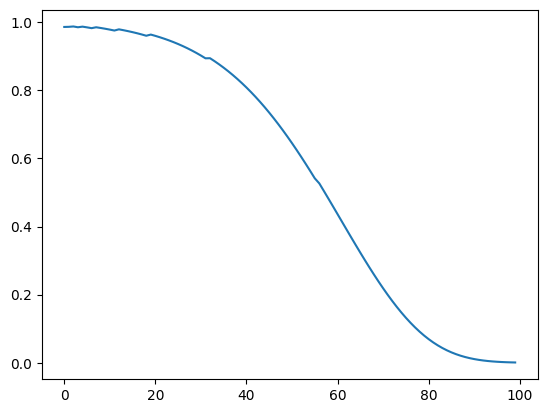

In [ ]:
plt.plot(torch.exp(log_probs_list[2]))